   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 MB 26.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 1.9 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 84.1 MB/s eta 0:00:00:00:0100:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cesium 0.12.4 

2025-06-14 08:30:29.196286: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749889829.410761      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749889829.475419      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Libraries imported successfully.
Hugging Face token retrieved successfully.
BitsAndBytesConfig for 4-bit quantization is configured.


tokenizer_config.json:   0%|          | 0.00/50.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/301 [00:00<?, ?B/s]

Pad token set to EOS token.


config.json:   0%|          | 0.00/844 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/20.9k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/1.46G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/185 [00:00<?, ?B/s]

Quantized model 'meta-llama/Llama-3.2-3B' and tokenizer loaded.
Model VRAM footprint: 2.20 GB


Map:   0%|          | 0/133799 [00:00<?, ? examples/s]


[INFO] Training on a fraction of the data: 133 samples (0%).
Dataset loaded and tokenized.


No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.



LoRA configuration applied.
trainable params: 9,175,040 || all params: 3,221,924,864 || trainable%: 0.2848

Cloning initial LoRA weights for later comparison...
Cloned 224 trainable LoRA parameter tensors.

Starting LoRA fine-tuning...


Step,Training Loss
10,2.282800


Fine-tuning complete.

Calculating weight changes for individual LoRA layers...
Individual LoRA matrix analysis complete.

Aggregating results by main transformer layer...
Aggregated analysis complete. Results saved to /kaggle/working/lora_finetune_results/aggregated_layer_change_analysis.csv
Top 5 Layers by Aggregated Mean Absolute Change:
    layer_num  agg_mean_change  std_of_mean_changes  agg_mean_absolute_change  \
0           0     3.259625e-06             0.000006                  0.000767   
27         27     6.619216e-07             0.000005                  0.000747   
22         22    -9.968601e-07             0.000004                  0.000724   
1           1    -3.639186e-07             0.000005                  0.000719   
2           2     3.588259e-06             0.000010                  0.000711   

    std_of_absolute_changes  
0                  0.000207  
27                 0.000106  
22                 0.000137  
1                  0.000162  
2                  0

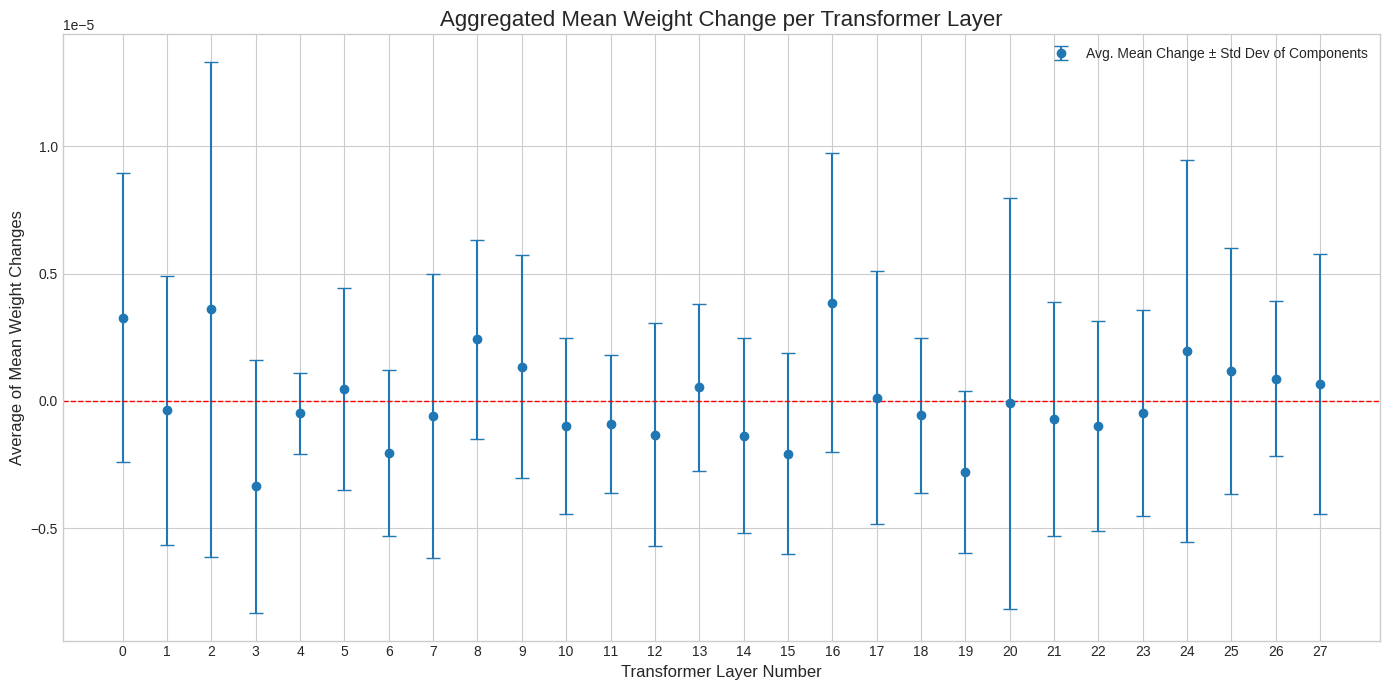

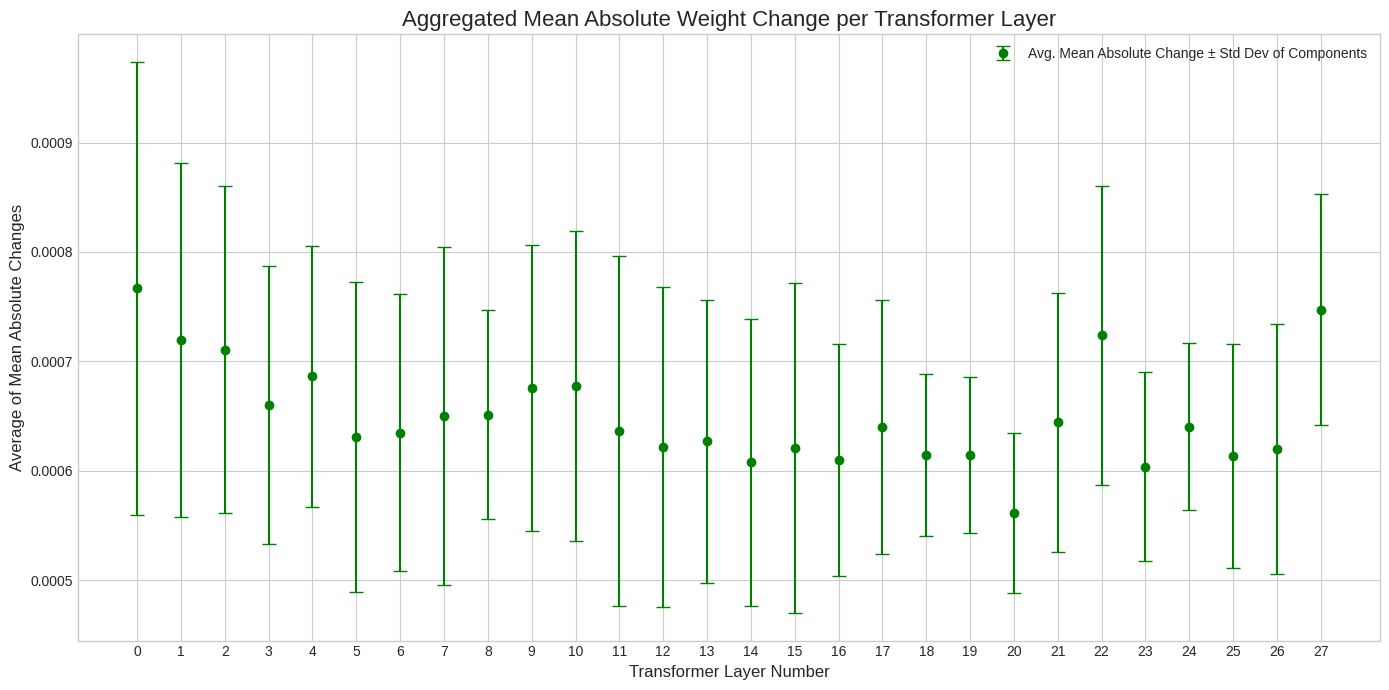

In [1]:
# Part 1: Setup and Configuration
# Step 1: Install required libraries quietly
!pip install -q transformers datasets peft bitsandbytes accelerate matplotlib seaborn

# Step 2: Import necessary modules
import os
import json
import copy
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from kaggle_secrets import UserSecretsClient
from datasets import Dataset
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    TrainingArguments,
    Trainer,
    DataCollatorForLanguageModeling,
    BitsAndBytesConfig
)
from peft import get_peft_model, LoraConfig

print("Libraries imported successfully.")

# --- Configuration ---
# Adjust this fraction to control the size of the training dataset.
DATA_FRACTION = 0.001

# The model to be fine-tuned.
MODEL_ID = "meta-llama/Llama-3.2-3B" # Your specified model

# The output directory for training artifacts and results
OUTPUT_DIR = "/kaggle/working/lora_finetune_results"
# ---------------------






# Part 2: Authentication, Model & Data Loading (with QLoRA)

# Step 3: Set up Hugging Face authentication (Corrected)
try:
    user_secrets = UserSecretsClient()
    # CORRECTED: Using your original secret name "3b_token"
    hf_token = user_secrets.get_secret("hf_token")
    print("Hugging Face token retrieved successfully.")
except Exception as e:
    print(f"Could not retrieve Hugging Face token. Please ensure the '3b_token' secret is set. Error: {e}")
    hf_token = None # Set token to None if retrieval fails

if hf_token is None:
    raise ValueError("Hugging Face token not found. Cannot proceed with a gated model.")

# Step 4: Define Quantization Config for QLoRA
# This loads the model in 4-bit precision, drastically reducing VRAM usage.
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
    bnb_4bit_use_double_quant=True,
)
print("BitsAndBytesConfig for 4-bit quantization is configured.")

# Step 5: Load Tokenizer and Quantized Model (Corrected)
tokenizer = AutoTokenizer.from_pretrained(
    MODEL_ID,
    token=hf_token  # CORRECTED: Explicitly passing the token
)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
    print("Pad token set to EOS token.")

model = AutoModelForCausalLM.from_pretrained(
    MODEL_ID,
    quantization_config=bnb_config,
    device_map="auto",
    token=hf_token  # CORRECTED: Explicitly passing the token
)
print(f"Quantized model '{MODEL_ID}' and tokenizer loaded.")
print(f"Model VRAM footprint: {model.get_memory_footprint() / 1e9:.2f} GB")

# Step 6: Load and Tokenize the Dataset (This part was correct, but included for completeness)
json_path = "/kaggle/input/mech-interp-data/numbered_qa_strings.json"
with open(json_path, 'r') as f:
    raw_data = json.load(f)

hf_dataset = Dataset.from_dict({"text": list(raw_data.values())})

def tokenize_function(examples):
    return tokenizer(
        examples["text"],
        truncation=True,
        max_length=256,
    )

tokenized_dataset = hf_dataset.map(tokenize_function, batched=True, remove_columns=["text"])

if 0 < DATA_FRACTION < 1:
    tokenized_dataset = tokenized_dataset.shuffle(seed=42).select(
        range(int(len(tokenized_dataset) * DATA_FRACTION))
    )
    print(f"\n[INFO] Training on a fraction of the data: {len(tokenized_dataset)} samples ({DATA_FRACTION:.0%}).")

print("Dataset loaded and tokenized.")









# Part 3: LoRA Configuration and Training

# Step 7: Apply LoRA configuration using PEFT
lora_config = LoraConfig(
    r=16,                # Rank of the update matrices. Higher rank means more trainable parameters.
    lora_alpha=32,       # LoRA scaling factor.
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj"], # Target all attention projections
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM",
)

model = get_peft_model(model, lora_config)
print("\nLoRA configuration applied.")
model.print_trainable_parameters()

# Step 8: Clone the initial state of ONLY the trainable LoRA weights
print("\nCloning initial LoRA weights for later comparison...")
original_state_dict = {
    name: param.clone().cpu()
    for name, param in model.named_parameters() if param.requires_grad
}
print(f"Cloned {len(original_state_dict)} trainable LoRA parameter tensors.")

# Step 9: Set up Training Arguments
training_args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    num_train_epochs=1,
    per_device_train_batch_size=2,      # Can use a slightly larger batch size with QLoRA
    gradient_accumulation_steps=4,
    learning_rate=2e-4,                 # Standard learning rate for LoRA
    logging_steps=10,
    fp16=False,                         # Must be False for 4-bit training
    bf16=True,                          # Use bfloat16 for training if available (on Ampere GPUs like A100/T4)
    save_strategy="no",
    report_to="none",
)

# Step 10: Create the Trainer and start fine-tuning
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset,
    data_collator=DataCollatorForLanguageModeling(tokenizer, mlm=False),
)

print("\nStarting LoRA fine-tuning...")
trainer.train()
print("Fine-tuning complete.")
model.eval() # Switch model to evaluation mode







 

# [PREVIOUS CODE - Parts 1, 2, and 3 are UNCHANGED]
# ... model is trained, trainer.train() is complete.

# Part 4: Analysis of LoRA Weight Changes (with Layer Aggregation)

print("\nCalculating weight changes for individual LoRA layers...")
final_state_dict = {
    name: param.cpu()
    for name, param in model.named_parameters() if param.requires_grad
}
analysis_results = []

for name, final_tensor in final_state_dict.items():
    if name in original_state_dict:
        original_tensor = original_state_dict[name]
        delta = final_tensor.float() - original_tensor.float()
        
        analysis_results.append({
            "layer_name": name,
            "mean_change": delta.mean().item(),
            "variance_change": delta.var().item(),
            "mean_absolute_change": torch.abs(delta).mean().item(),
            "variance_absolute_change": torch.abs(delta).var().item(),
        })

df_detailed_results = pd.DataFrame(analysis_results)
print("Individual LoRA matrix analysis complete.")


# --- NEW: AGGREGATION STEP ---
print("\nAggregating results by main transformer layer...")

# Helper function to extract the layer number from the name string
def get_layer_number(name):
    parts = name.split('.')
    if 'layers' in parts:
        try:
            layer_idx = parts.index('layers')
            return int(parts[layer_idx + 1])
        except (ValueError, IndexError):
            return None
    return None

df_detailed_results['layer_num'] = df_detailed_results['layer_name'].apply(get_layer_number)

# Filter out any weights that aren't part of a transformer layer (e.g., if other modules were made trainable)
df_layers_only = df_detailed_results.dropna(subset=['layer_num']).copy()
df_layers_only['layer_num'] = df_layers_only['layer_num'].astype(int)

# Group by the layer number and calculate the average and std dev of the metrics
# This gives us one row per transformer layer
df_aggregated = df_layers_only.groupby('layer_num').agg(
    # For the first plot: The average of the mean changes across all LoRA matrices in this layer
    agg_mean_change=('mean_change', 'mean'),
    # Error bar: The standard deviation of those mean changes, showing their spread
    std_of_mean_changes=('mean_change', 'std'),

    # For the second plot: The average of the mean *absolute* changes. This is the best indicator of total change.
    agg_mean_absolute_change=('mean_absolute_change', 'mean'),
    # Error bar: The standard deviation of absolute changes, showing if learning was uniform in the layer
    std_of_absolute_changes=('mean_absolute_change', 'std')
).reset_index()


# Save the aggregated results to a new CSV file
csv_path = os.path.join(OUTPUT_DIR, "aggregated_layer_change_analysis.csv")
df_aggregated.to_csv(csv_path, index=False)
print(f"Aggregated analysis complete. Results saved to {csv_path}")
print("Top 5 Layers by Aggregated Mean Absolute Change:")
print(df_aggregated.sort_values(by="agg_mean_absolute_change", ascending=False).head())


# Part 5: Visualization of Aggregated Layer-wise Changes

print("\nGenerating aggregated plots...")
plt.style.use('seaborn-v0_8-whitegrid')

# Plot 1: Aggregated Mean Change in Weights per Transformer Layer
fig, ax = plt.subplots(figsize=(14, 7))
ax.errorbar(
    df_aggregated['layer_num'],
    df_aggregated['agg_mean_change'],
    yerr=df_aggregated['std_of_mean_changes'],
    fmt='o',
    capsize=5,
    label='Avg. Mean Change ± Std Dev of Components'
)
ax.set_title('Aggregated Mean Weight Change per Transformer Layer', fontsize=16)
ax.set_xlabel('Transformer Layer Number', fontsize=12)
ax.set_ylabel('Average of Mean Weight Changes', fontsize=12)
ax.axhline(0, color='red', linestyle='--', linewidth=1)
ax.set_xticks(df_aggregated['layer_num']) # Ensure every layer number is a tick
plt.legend()
plt.tight_layout()
plt.show()

# Plot 2: Aggregated Mean Absolute Change in Weights per Transformer Layer
fig, ax = plt.subplots(figsize=(14, 7))
ax.errorbar(
    df_aggregated['layer_num'],
    df_aggregated['agg_mean_absolute_change'],
    yerr=df_aggregated['std_of_absolute_changes'],
    fmt='o',
    color='green',
    capsize=5,
    label='Avg. Mean Absolute Change ± Std Dev of Components'
)
ax.set_title('Aggregated Mean Absolute Weight Change per Transformer Layer', fontsize=16)
ax.set_xlabel('Transformer Layer Number', fontsize=12)
ax.set_ylabel('Average of Mean Absolute Changes', fontsize=12)
ax.set_xticks(df_aggregated['layer_num']) # Ensure every layer number is a tick
plt.legend()
plt.tight_layout()
plt.show()
